# **Chain**

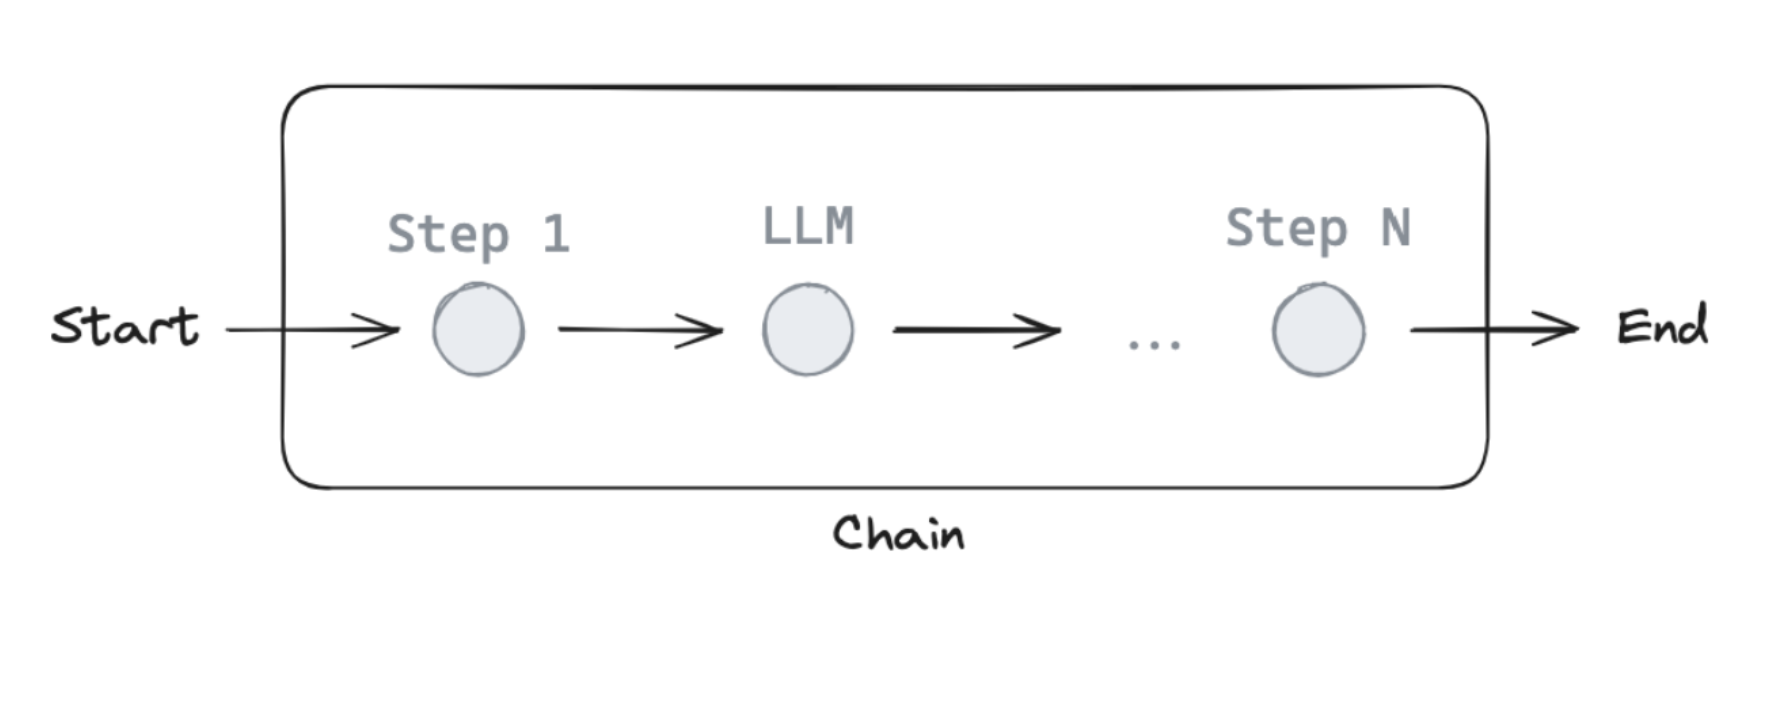

In [50]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

**Messages**

In [51]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


**Chat Models**

In [53]:
import os
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [54]:
from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [56]:
# invoke
result = model.invoke("Hello")

In [57]:
result.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': []}

**Tools**

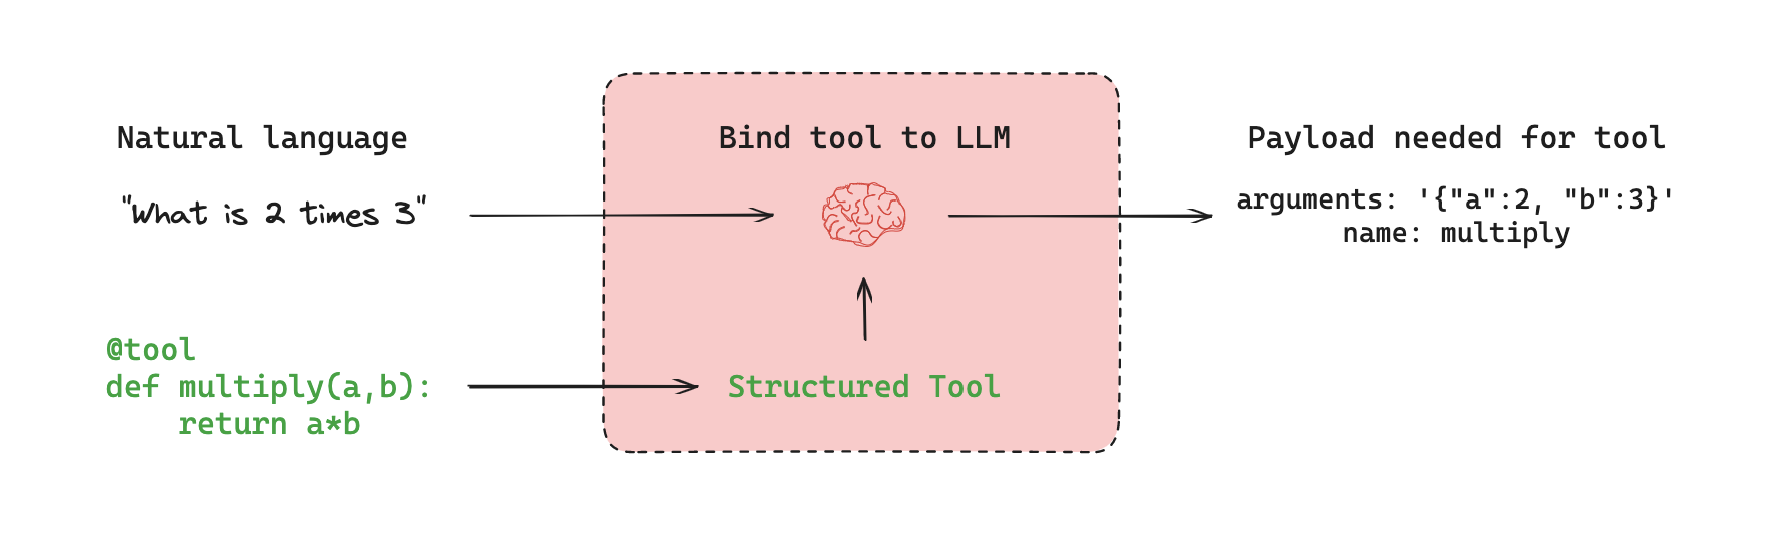

In [58]:
# Defining a tool
def multiply(a: int, b: int) -> int:
  """
  Multiply two numbers

  Args:
    a (int): first number
    b (int): second number

  Returns:
    result: a * b
  """
  return a * b

In [59]:
# Binding tool with model
llm_with_tool = model.bind_tools([multiply])

In [60]:
function_call = llm_with_tool.invoke(
    [HumanMessage(content="What is 2 multiply by 3 ?", name="Anas")]
)
function_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-2b74b120-1535-4077-aad3-dad1d1315ef2-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': 'fb708e16-d7e1-4fff-a0ea-379583c4cf4c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 21, 'output_tokens': 3, 'total_tokens': 24, 'input_token_details': {'cache_read': 0}})

In [61]:
function_call.additional_kwargs["function_call"]

{'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}

**Using messages as stat**

In [62]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

In [63]:
class MessagesState(TypedDict):
  messages: list[AnyMessage]

**Reducers**

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will will override the prior messages value.

As our graph runs, we want to append messages to to our messages state key.

We can use reducer functions address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our messages key with the add_messages reducer function as metadata.

In [64]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
  messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built **MessagesState!**

**MessagesState** is defined:

- With a pre-build single messages key
- This is a list of AnyMessage objects
- It uses the add_messages reducer

We'll usually use **MessagesState** because it is less verbose than defining a custom **TypedDict**, as shown above.

In [65]:
from langgraph.graph import MessagesState

class MessageConversationState(MessagesState):
  # Add any keys needed beyond messages, which is pre-built
  pass

In [66]:
# Initial State
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Assistant"),
    HumanMessage(content="I am looking for information on marine biology.", name="Anas")
]

# New Message
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Assistant")

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Assistant', id='3808e013-6a8f-4b05-93f0-b73288d38d49'),
 HumanMessage(content='I am looking for information on marine biology.', additional_kwargs={}, response_metadata={}, name='Anas', id='2e6d8eb8-e836-452b-8bd5-661372a9340c'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Assistant', id='ee6770d7-dbbd-44c9-b574-b3a0bb0bc8f4')]

**Bulding our Graph**

In [68]:
from langgraph.graph import StateGraph, START, END

In [67]:
# Defining a node
def call_llm_with_tool(state: MessageConversationState):
  return {"messages": [llm_with_tool.invoke(state["messages"])]}

In [69]:
# building grapg
builder = StateGraph(MessageConversationState)

# Add Nodes
builder.add_node("call_llm_with_tool", call_llm_with_tool)

# Add Edge
builder.add_edge(START, "call_llm_with_tool")
builder.add_edge("call_llm_with_tool", END)

# compile
graph = builder.compile()

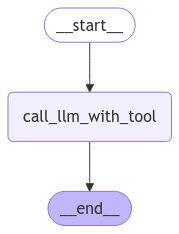

In [70]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [72]:
# Invoke
messages = graph.invoke({"messages": HumanMessage(content="Hello", name="Anas")})
for msg in messages["messages"]:
  msg.pretty_print()

================================ Human Message =================================
Name: Anas

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [73]:
# Invoke
messages = graph.invoke({"messages": HumanMessage(content="What is 2 multiplied by 6", name="Anas")})
for msg in messages["messages"]:
  msg.pretty_print()

================================ Human Message =================================
Name: Anas

What is 2 multiplied by 6
================================== Ai Message ==================================
Tool Calls:
  multiply (6a5dd277-5cf9-454a-adda-0a1b83836ccc)
 Call ID: 6a5dd277-5cf9-454a-adda-0a1b83836ccc
  Args:
    a: 2.0
    b: 6.0
